# Clothing Item Classification using Convolutional Neural Network

### The Model is trained over Fashion MNIST dataset

For our course project we are given the task of create a neural network model using CNN which can classify different types of clothing.

For model Training we are using Fashion MNIST dataset which have total of 70,000 small square 28×28 pixel grayscale images of cloting 60,000 for training and 10,000 for testing the model. It has 9 classes and name of each class is mentioned below.

In [ ]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
# Importing some helper libraries
import os
import requests
import zipfile
import math
import numpy as np
import matplotlib.pyplot as plt
from random import randint

## Initialising the dataset
Lets load the `Fashion MNIST` dataset using `tfds.load()` function and then extact out the actual dataset and the metada.
Now extacting the training_dataset and test_dataset from the whole dataset.

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
# Define the name of each class of the dataset

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Normalise the dataset

Now we have to Normalise the dataset as the pixel value of the greyscale images is in integral range `[0,255]`. But the model works properly in the decimal value in the range `[0,1]`. So creating a normalizing function which does this work of conversion from integer range `[0,255]` to decimal range `[0,1]`.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

## Exploring the dataset
Let's plot an image to see what it looks like.

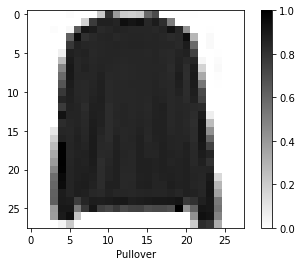

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(randint(0, 100)):
  pass
image = image.numpy().reshape((28,28))
# Plot the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[label])
plt.show()

Displaying the first 25 images from the training dataset and display the class name below each image.

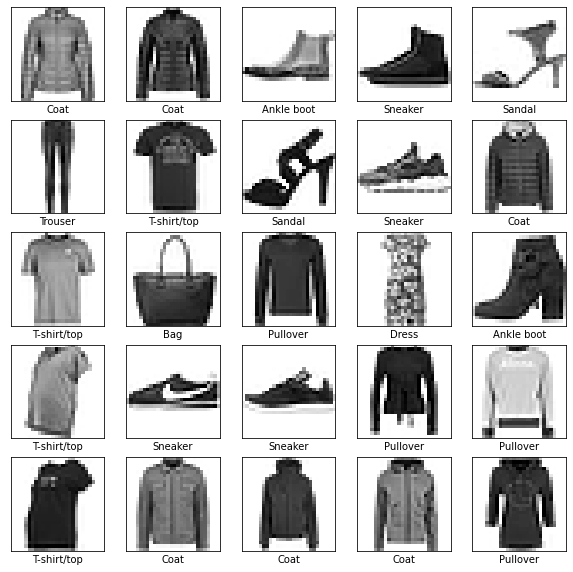

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Creating the Model
1. Now first using the `tf.keras.Sequential` which works as a wrapper for all the layers of the CNN.
2. The first layer is a `Conv2D` with kernal (3,3) which gives 32 convoluted images.
3. The second layer is a `MaxPooling2D` (2,2) with a stride of 2 which reduce the size of the 32 images
4. The third layer of `Conv2D` with kernal (3,3) takes 32 MaxPooled images and output further 64 convoluted images.
5. In the fourth layer we are using the same second layer of `MaxPooling`.
6. In the fifth layer we `flattening` out the image with gives out a pixel matrix of (1,128)
7. In the sixth layer we are passing the flattened image into a `relu` activation function.
8. In the last seventh layer we are passing the relu activated flattened image into one more activation function that is `softmax`.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Now compiling the model with sime extra parameters for the training.

We are using `Adam` as the optimizer, `Sparse Categorical Cross Entropy` as the loss function and `Accuracy` as training matric.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Now defining the batches for training.

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

Defining the path to the file storing weights and bias value for the trianed model.

In [ ]:
checkpoint_path = "model/weights.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

Initialising the checkpoint function

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Tring the model or not

Here you have to tell wether you want to train the model from scratch or use the parameters of a trained model.

Set the `train` variable below as `True` if you want train or set it to `False` if you want to use trained model. (False by default)

In [ ]:
train = False

#### Defining some important funtion to download files from Google Drive.

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

If the `train` variable is set to False then downloading the parameters of trained model from my google frive in from of zip file and then unzipping the file.

In [ ]:
if not train:
    file_id = '10yJdhCUbNBHqfkGmtP--9F9l0SC6LOLS'
    destination = 'data.zip'
    download_file_from_google_drive(file_id, destination)
    
    with zipfile.ZipFile("data.zip","r") as zip_ref:
        zip_ref.extractall(".")

    os.remove('data.zip')

#### Here if the `train` vaiable is set to True then calling the `model.fit()` function to trin the model from sctatch for 10 epochs and if the `train` variable is set to False then calling the `model.load_weights()` function to load the parameters of trained model.

In [ ]:
if train:
    model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE), callbacks=[cp_callback])
else:
    model.load_weights(checkpoint_path)

#### Now lets Evaluate the model and check its accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 5s 15ms/step - loss: 0.7102 - accuracy: 0.9184
Accuracy on test dataset: 0.9190000295639038


## Predections of our model

Here I have defined a `predict()` function which first takes a random batch number in range (1, 10) and then a random image number in range (0,31) as each batch is of size 32. Then we pass the image into the `model.predict` function which gives the predections of of probability of each clothing item. Then we just print the image, its original label and the predicted label with highest percentage.

In [ ]:
def predict():
    rand_batch = randint(1, 10)
    rand_pos = randint(0, 31)
    for test_images, test_labels in test_dataset.take(rand_batch):
        test_images = test_images.numpy()
        test_labels = test_labels.numpy()

    predictions = model.predict(test_images)
    predicated_percentage = {}
    for i in range(len(predictions[rand_pos])):
        predicated_percentage[(np.round(predictions[rand_pos][i], decimals = 4) / 1) * 100] = i

    predicated_percentage_sorted = sorted(predicated_percentage, reverse=True)[:-1] 
    
    first = True

    print("Label:      " + "\x1B[32m%s\x1b[0m" % class_names[test_labels[rand_pos]])

    for i in predicated_percentage_sorted:
        if first:
            if class_names[predicated_percentage[i]] == class_names[test_labels[rand_pos]]:
                print("Predicted: ", "\x1B[32m%s\x1b[0m" % (class_names[predicated_percentage[i]] + " " + str(np.round(i, decimals = 2)) + "%"), end = "")
            else:
                print("Predicted: ", "\x1B[31m%s\x1b[0m" % (class_names[predicated_percentage[i]] + " " + str(np.round(i, decimals = 2)) + "%"), end = "")
            first = False
        else:
            print(", " + class_names[predicated_percentage[i]] + " " + str(np.round(i, decimals = 2)) + "% ", end = "")

    plt.figure()
    image = test_images[rand_pos].reshape((28,28))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

#### Just call the `predict()` function do predicition on random image.

Label:      T-shirt/top
Predicted:  T-shirt/top 99.99%, Shirt 0.01% 

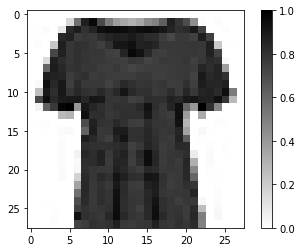

In [ ]:
predict()

Label:      Ankle boot
Predicted:  Ankle boot 100.0%

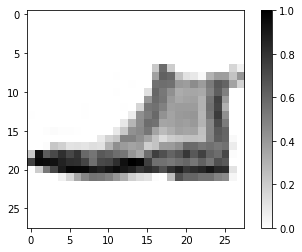

In [ ]:
predict()

Label:      Pullover
Predicted:  Coat 50.38%, Pullover 49.62% 

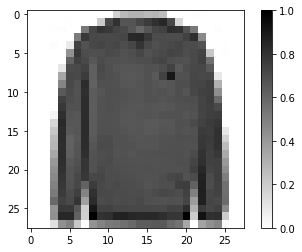

In [ ]:
predict()

#### Now in the blow code we are showing the image and plotting the graph of possibility of each cloting item. `plot_image` function shows the image and `plot_value_array` shows the graph and `plot_prediction` function does the prediction.

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_prediction():
    rand_batch = randint(1, 10)
    for test_images, test_labels in test_dataset.take(rand_batch):
        test_images = test_images.numpy()
        test_labels = test_labels.numpy()

    prediction = model.predict(test_images)
    i = randint(0, 10)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_image(i, prediction, test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, prediction, test_labels)
    _ = plt.xticks(range(10), class_names, rotation=45)

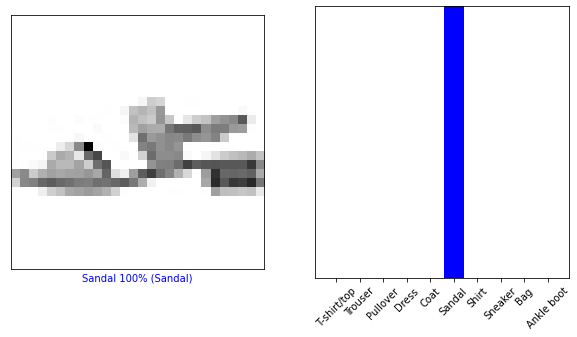

In [ ]:
plot_prediction()

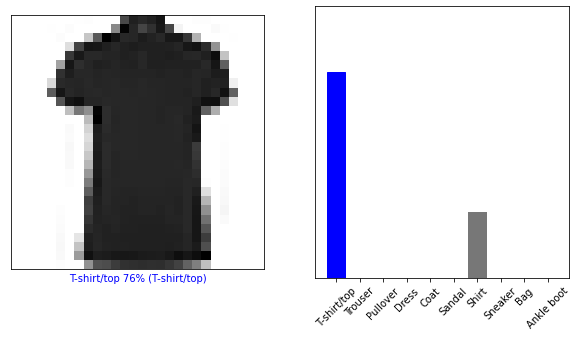

In [ ]:
plot_prediction()

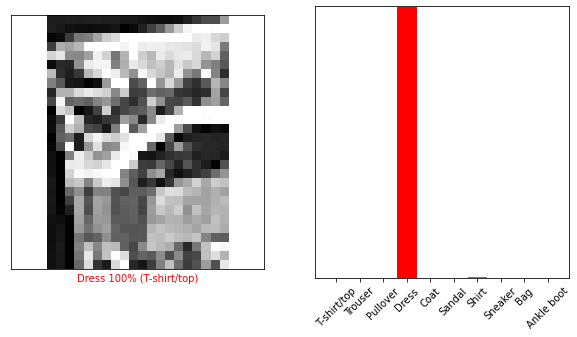

In [ ]:
plot_prediction()

## Thank You 😇